In [59]:
# dependency 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool,PanTool,WheelZoomTool,BoxZoomTool,ResetTool,UndoTool,RedoTool

def checkDF(df):
    requirements = ['Provider State', 'Cost', 'BEDS', 'Provider name']
    errorFlag = False
    for req in requirements:
        if not req in df:
            print(f'DF structure error: dataframe must include "{req}". please confirm your dataframe:-(')
            errorFlag = True
            break
    if not errorFlag:
        return df

# read the csv as df and add the new columns where county names without 'city' and 'county' is placed
df = checkDF(pd.read_csv('DATA/main_cleaned.csv'))
df.head()


,Unnamed: 0,Provider Id,Provider City,Provider Street Address,Provider State,Provider name,Hospital Ownership,Hospital overall rating,Average Total Payments,Average Medicare Payments,BEDS,Cost
0,0,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,5777.24,4763.73,420.0,1013.51
1,92,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4894.76,3865.50,420.0,1029.26
2,184,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,10260.21,9167.08,420.0,1093.13
3,276,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,6542.08,5438.50,420.0,1103.58
4,368,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4596.39,3618.93,420.0,977.46


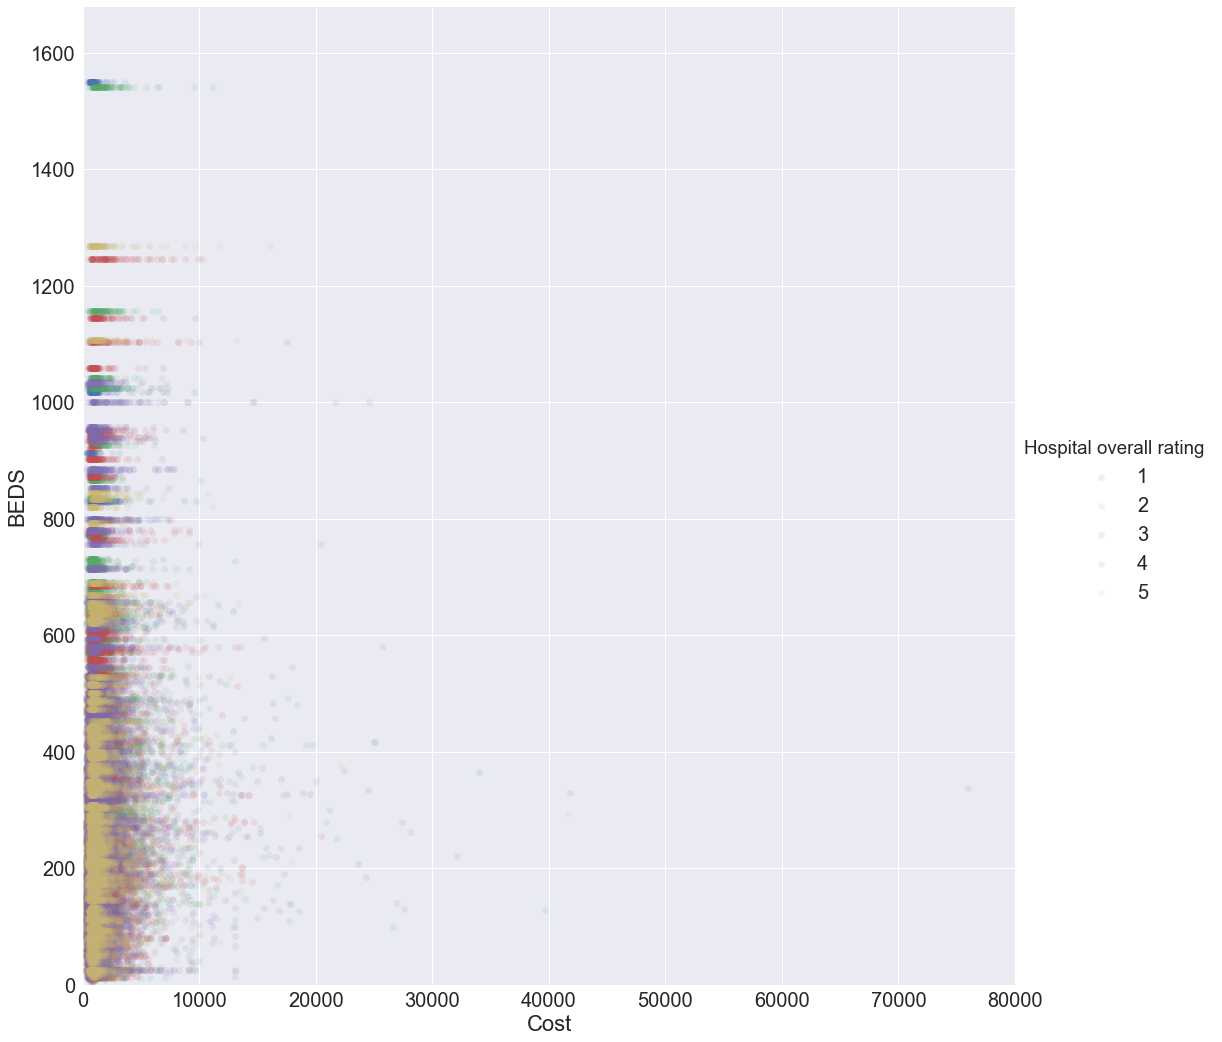

In [61]:
states = df.groupby('Provider State').mean().sort_values(by=['Cost'], ascending=False).index
sns.barplot(x='Provider State', y='Cost', data=df, order=states)
sns.set(rc={'figure.figsize':(100,150)}, font_scale=7)
plt.savefig('state_cost.png')
plt.show()

In [4]:
# sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
# plt.ylim(0,)
# plt.xlim(0,)
# # plt.savefig('income_charge.png')
# plt.show()

In [5]:
# sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
# plt.ylim(0,)
# plt.xlim(0,4000)
# # plt.savefig('income_charge.png')
# plt.show()

In [12]:
def showPlot(df, state, rating=[1,2,3,4,5]):
    if not state in list(df['Provider State']):
        print('your state input might be wrong. please check your input!')
    elif not isinstance(rating, list) or len(rating)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        dfbyState = df[df['Provider State'] == state]
        dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin(rating)]
        sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=dfbyState_Rating, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.3})
        sns.set(font_scale=2)
        plt.ylim(0,)
        plt.xlim(0,4000)
        plt.title(f'Cost-Size relationship in {state}')
#         plt.savefig(f'cost_size_rating_in{state}.png')
        plt.show()

In [13]:
def f(STATE):
    showPlot(df,STATE)
states = df.groupby('Provider State').mean().index
ipywidgets.interact(f, STATE=states);

A Jupyter Widget

In [10]:
from IPython.display import display
import ipywidgets as widgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
from bokeh.models import Range1d
import numpy as np

# drop data that 'BEDS' > 0
df_hasbeds = df[df['BEDS'] > 0]
states = df_hasbeds.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='AK')
exg_r = []

def initialize_source():
    return ColumnDataSource(data=dict(x=[],y=[],prov=[]))

def initialize_figure(title='Cost-Size relationship', tools=[hover,box,pan,undo,redo,reset], plot_width=640, plot_height=400):
        fig = figure(title=title, tools=tools, plot_width=plot_width, plot_height=plot_height)
        x = np.array([])
        y = np.array([])
        fig.scatter(x, y)     
        return fig
        
# Event handler
def on_value_change(change):
    print('on_val_ch: ' + str(len(exg_r)))
    for r in exg_r:
        if r.visible:
            r.visible=False
    
#     r = fig.line("x", "y", source=initialize_source(), legend=change.new)
#     r.visible=False
#     print(change.new)
    new_dfbyState = df_hasbeds[df_hasbeds['Provider State'] == change.new]
    overlayPlot(new_dfbyState, change.new, [np.random.randint(1,3)])
#     for i in [1,2,3,4,5]:
#         df_State_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([i])]
#         x = df_State_Rating['Cost']
#         y = df_State_Rating['BEDS']
#         provider = df_State_Rating['Provider name']
#         source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
#         r = fig.scatter("x", "y", source=source, color = colors[i-1], legend=str(i))
#         push_notebook(handle=t)
#     print(new_dfbyState)
#     new_dfbyState_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([1,2,3,4,5])]
#     x=new_dfbyState_Rating['Cost']
#     y=new_dfbyState_Rating['BEDS']
#     provider=new_dfbyState_Rating['Provider name'] 
#     source.data=dict(x=x,y=y,desc=provider)
#     t = show(f, notebook_handle=True)
    t = show(fig, notebook_handle=True)
    
    push_notebook(handle=t)
    
def overlayPlot(df_State, state, ratings):
    colors = ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']
    if not isinstance(ratings, list) or len(ratings)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        for i in ratings:
            df_State_Rating = df_State[df_State["Hospital overall rating"].isin([i])]
            x = df_State_Rating['Cost']
            y = df_State_Rating['BEDS']
            provider = df_State_Rating['Provider name']
            source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
            r = fig.scatter("x", "y", source=source, color = colors[i-1], legend=str(i) + state)
            r.name= f'{i} {state}'
            exg_r.append(r)
    
    for r in exg_r:
        print(f'{r.name}, {r.visible}')   

d.observe(on_value_change, names='value')

hover = HoverTool(tooltips=[
    ("name:", "@prov"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')

dfbyState = df_hasbeds[df_hasbeds['Provider State'] == 'AK']

display(d)
overlayPlot(dfbyState, 'AK',[4])
output_notebook()

# fig.title.text = "Rolling Standard Deviation"
fig.xaxis.axis_label = 'Cost'
fig.yaxis.axis_label = 'Size (Bed count)'
# fig.x_range=Range1d(0,4000)
# fig.y_range=Range1d(0,700)
t = show(fig, notebook_handle=True)

A Jupyter Widget

4 AK, True


Loading BokehJS ...

In [ ]:
def checkDF(df):
    requirements = ['Provider State', 'Cost', 'BEDS', 'Provider name']
    errorFlag = False
    for req in requirements:
        if not req in df:
            print(f'DF structure error: dataframe must include "{req}". please confirm your dataframe:-(')
            errorFlag = True
            break
    if not errorFlag:
        return df
    
checkDF(pd.DataFrame())

In [ ]:
df_hasbeds = df[df['BEDS'] > 0]
df_hasbeds

In [ ]:
df

In [48]:
from IPython.display import display
import ipywidgets as widgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
from bokeh.models import Range1d
import numpy as np
from bokeh.transform import factor_cmap

# drop data that 'BEDS' > 0
df_hasbeds = df[df['BEDS'] > 0]
states = df_hasbeds.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='AK')
exg_r = []
hover = HoverTool(tooltips=[
    ("name:", "@prov"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

colormap = {1:'#d7191c', 2:'#fdae61', 3:'#ffffbf', 4:'#a6d96a', 5:'#1a9641'}
# colors = [colormap[x] for x in df_hasbeds['Hospital overall rating']]
# colors = ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']

fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')
source= ColumnDataSource(data=dict(x=[],y=[],prov=[]))
# print(source)
# r = fig.scatter("x", "y", source=source)
# t = show(fig, notebook_handle=True)
        
def setPlot(df, state, ratings=[np.random.randint(2,4)]):
#     source= ColumnDataSource(data=dict(x=[],y=[],prov=[]))
#     source.data = dict(x=[],y=[],prov=[])
    
#     fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')
#     i = ratings[0]
    df_State = df[df['Provider State'] == state]
#     df_State['Color'] = list[colormap[x] for x in df_State['Hospital overall rating']]
#     colors = [cmap[x] for x in df_State['Hospital overall rating']]
    
#     print(colors)
#     for i in ratings:
#         print(f'i={i}')
#     df_State_Rating = df_State[df_State["Hospital overall rating"].isin([i])]
#         print(df_State_Rating['Hospital overall rating'])
    x = df_State['Cost']
    y = df_State['BEDS']
    provider = df_State['Provider name']
    colormap = {1:'#d7191c', 2:'#fdae61', 3:'#ffffbf', 4:'#a6d96a', 5:'#1a9641'}
    colors = [colormap[x] for x in df_State['Hospital overall rating']]
    
    source.data = dict(x=x,y=y,prov=provider,colors=colors)
#         source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
#         print(source)
    
#     r = fig.scatter("x", "y", source=source)
#     print(colors)
    fig.circle(x='x', y='y', source=source, color=colors, fill_alpha=0.1)
#     r.name= f'{i}-{state}'   
#     if not r.name in exg_r:
#         exg_r.append(r)
#             print(f'{r.name} added')
#         print(f'len(exg_r) = {len(exg_r)}')
#     t = show(fig, notebook_handle=True)

    # Event handler
def on_value_change(change):
#     fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')
#     print('on_val_ch: ' + str(len(exg_r)))
    for r in exg_r:
        if r.visible:
            r.visible=False
#     print(f'on_val_ch: len(exg_r)')
    
    setPlot(df_hasbeds, change.new, [1,2,3,4,5])
#     setPlot(df_hasbeds, change.new, 4)
#     for r in exg_r:
#         print(f'on_val_ch: {r.name}-{r.visible}')
# #     print(f'{fig}')
#     t = show(fig, notebook_handle=True)
    
    push_notebook(handle=t)
    

d.observe(on_value_change, names='value')


# dfbyState = df_hasbeds[df_hasbeds['Provider State'] == 'AK']

display(d)

setPlot(df_hasbeds, 'AK', [1,2,3,4,5])

output_notebook()

# fig.title.text = "Rolling Standard Deviation"
fig.xaxis.axis_label = 'Cost'
fig.yaxis.axis_label = 'Size (Bed count)'
fig.x_range=Range1d(0,4000)
fig.y_range=Range1d(0,700)
t = show(fig, notebook_handle=True)

A Jupyter Widget

RuntimeError: 
Supplying a user-defined data source AND iterable values to glyph methods is
not possibe. Either:

Pass all data directly as literals:

    p.circe(x=a_list, y=an_array, ...)

Or, put all data in a ColumnDataSource and pass column names:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))
    p.circe(x='x', y='x', source=source, ...)



In [55]:
# from bokeh.plotting import figure, show, output_file
# from bokeh.sampledata.iris import flowers

from IPython.display import display
import ipywidgets as widgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
from bokeh.models import Range1d
import numpy as np

# drop data that 'BEDS' > 0
df_hasbeds = df[df['BEDS'] > 0]
states = df_hasbeds.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='AK')
exg_r = []
hover = HoverTool(tooltips=[
    ("name:", "@prov"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

colormap = {1:'#d7191c', 2:'#fdae61', 3:'#ffffbf', 4:'#a6d96a', 5:'#1a9641'}

df_State = df_hasbeds[df_hasbeds['Provider State'] == 'CA']

colors = [colormap[x] for x in df_State['Hospital overall rating']]
p = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title='Cost-Size relationship')
p.xaxis.axis_label = 'Cost'
p.yaxis.axis_label = 'Size (Bed count)'

x = df_State['Cost']
y = df_State['BEDS']
provider = df_State['Provider name']
source= ColumnDataSource(data=dict(x=x,y=y,prov=provider))
# source.data = dict(x=x,y=y,prov=provider)

p.scatter(df_State["Cost"], df_State["BEDS"], color=colors, fill_alpha=0.1)
# p.scatter(x="Cost", y="BEDS", source=source, color=colors, fill_alpha=0.2)

# p.scatter(df_State["Cost"], df_State["BEDS"], color=colors, fill_alpha=0.2)

output_notebook()

t = show(p, notebook_handle=True)


Loading BokehJS ...

In [56]:
from IPython.display import display
import ipywidgets as widgets
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
from bokeh.models import Range1d
import numpy as np
from bokeh.transform import factor_cmap

x = [1,2]
y = [1,2]
provider=['a', 'b']
colors = ['#d7191c', '#fdae61']
    
source.data = dict(x=x,y=y,prov=provider,colors=colors)
fig.circle(x='x', y='y', source=source, color=factor_cmap('provider', palette=Spectral6, factors=fruits), fill_alpha=0.1)
show(fig)

NameError: name 'Spectral6' is not defined